# Customer Support Ticket Classification Model
**This notebook demonstrates the development of a Customer Support Ticket Classification model, a valuable tool for e-commerce platforms like Flipkart. By automatically categorizing incoming customer support tickets based on their description, this model enables faster and more efficient routing of issues to the appropriate teams. This automation not only improves response times and resolution rates, leading to enhanced customer satisfaction.**

**The notebook covers the entire process from data loading and preprocessing to model training, evaluation, and saving the best-performing model for potential deployment.In this model building Naive Bayes classifier was selected as the best model based on its performance during the model training, evaluation, and comparison steps.**

### Import Libraries

The following cell imports necessary libraries for data manipulation (pandas), text processing (re, nltk), visualization (matplotlib, seaborn), and machine learning (sklearn, xgboost, joblib).

In [1]:
# =====================================================
# Step 1: Import Libraries
# =====================================================
# Import necessary libraries for data manipulation, text processing, visualization, and modeling.
import pandas as pd
import numpy as np
import re # Regular expression operations for text cleaning.
import nltk # Natural Language Toolkit for text processing.
import matplotlib.pyplot as plt # For creating visualizations.
from nltk.corpus import stopwords # For accessing a list of common English stopwords.
from nltk.stem import WordNetLemmatizer # For reducing words to their base form.
from sklearn.feature_extraction.text import TfidfVectorizer # For converting text into TF-IDF features.
# Suppress all warnings in the notebook output for cleaner presentation.
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources (run this once)
# These resources are essential for various text preprocessing tasks like tokenization,
# removing stopwords, and lemmatization performed later in the notebook.
nltk.download('stopwords') # Download the list of stopwords.
nltk.download('punkt') # Download the Punkt tokenizer for splitting text into sentences and words.
nltk.download('wordnet') # Download WordNet, a lexical database for English, used by the lemmatizer.
nltk.download('averaged_perceptron_tagger') # Download a tagger for part-of-speech tagging, used by WordNetLemmatizer.
nltk.download('punkt_tab') # Download additional Punkt data for more accurate tokenization (added to fix potential LookupError).

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rojap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rojap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rojap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rojap\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rojap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load Dataset & Handle Missing Values/Duplicates

Load the dataset from a CSV file, standardize column names, and handle missing values and duplicate entries to ensure data quality.
The following cell explicitly removes rows with missing values in key columns and drop duplicate descriptions to clean the dataset. Reset the index and create new unique ticket IDs.

In [2]:
# =========================================================
# Step 2: Load Dataset & Handle Missing Values/Duplicates
# =========================================================
# Load the dataset from the specified CSV file into a pandas DataFrame.
# The file 'flipkart_ticket_dataset_augmented.csv' contains the raw data.
df = pd.read_csv("flipkart_ticket_dataset_augmented.csv")

# Standardize column names
# Rename columns to a consistent snake_case format for easier access and readability.
# This step assumes the original dataset has columns named 'TicketID', 'Description', and 'Category'.
df.rename(columns={
    "TicketID": "ticket_id",
    "Description": "description",
    "Category": "category"
}, inplace=True)

print("Original dataset shape:", df.shape)
print(df.head()) # Display the first few rows of the loaded DataFrame.

# =====================================================
# Step 3: Handle Missing Values & Duplicates
# =====================================================
# Remove rows with missing values in either the 'description' or 'category' columns.
# This ensures that only complete data is used for training and evaluation.
df.dropna(subset=["description", "category"], inplace=True)
# Remove duplicate rows based on the 'description' column.
# Keeping duplicate descriptions can lead to biased model training and evaluation.
df.drop_duplicates(subset=["description"], inplace=True)

# Reset Index and create new unique Ticket IDs
# Drop the existing 'ticket_id' column first as it might contain IDs from before dropping duplicates/NAs.
if 'ticket_id' in df.columns:
    df.drop('ticket_id', axis=1, inplace=True)

# Reset the DataFrame index after removing rows and create a new sequential 'ticket_id' column
# based on the new index. This provides unique IDs for the cleaned dataset.
df.reset_index(drop=True, inplace=True)
df.insert(0, "ticket_id", df.index + 1) # Insert the new 'ticket_id' column at the beginning.

print("\nFinal dataset shape after cleaning NA & duplicates:", df.shape)

Original dataset shape: (1750, 3)
   ticket_id                                 description           category
0          1        Why was extra delivery charge added?      Billing Issue
1          2      Unable to update my profile in the app  Technical Problem
2          3            Courier details are not updating       Order Status
3          4  What are your customer care working hours?      General Query
4          5            I was charged twice for my order      Billing Issue

Final dataset shape after cleaning NA & duplicates: (317, 3)


### Text Cleaning Function

Define and apply a function to preprocess the 'description' column. This involves converting text to lowercase, removing punctuation and special characters, tokenization, removing stopwords, and lemmatization.

In [3]:
# =====================================================
# Step 4: Text Cleaning Function
# =====================================================
# Define a set of English stopwords for efficient removal.
# Stopwords are common words (e.g., 'the', 'a', 'is') that typically don't add significant meaning
# for text classification and can be removed to reduce noise and dimensionality.
stop_words = set(stopwords.words('english'))
# Initialize the WordNet Lemmatizer for reducing words to their base form (lemma).
# Lemmatization groups together different inflected forms of a word (e.e., 'running', 'runs', 'ran' -> 'run'),
# which helps in reducing the vocabulary size and improving generalization.
lemmatizer = WordNetLemmatizer()

# Define a function to clean the text data.
def clean_text(text):
    # Ensure input text is a string to prevent errors during processing.
    # Handle cases where the input might be a list or other data types.
    if isinstance(text, list):
        # If input is a list of strings, join its elements into a single string.
        text = ' '.join(map(str, text))
    elif not isinstance(text, str):
        # If input is not a string or list, return an empty string as it cannot be processed.
        return ""

    # Convert all characters in the text to lowercase to ensure case-insensitivity.
    text = text.lower()
    # Remove punctuation, numbers, and special characters using regular expressions.
    # The pattern '[^a-z\s]' matches any character that is NOT a lowercase letter or a whitespace.
    # Replacing them with a space helps in separating words that were joined by punctuation.
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize the text into individual words (tokens) using NLTK's word_tokenize.
    # This splits the cleaned string into a list of words.
    tokens = nltk.word_tokenize(text)
    # Remove stopwords from the list of tokens.
    # This filters out common English words that are in the 'stop_words' set.
    tokens = [t for t in tokens if t not in stop_words]
    # Lemmatize the remaining tokens to reduce them to their base form.
    # The lemmatizer requires a part-of-speech tag, but by default, it uses 'noun' which is often sufficient.
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    # Join the processed tokens back into a single string, separated by spaces.
    # This forms the final cleaned text output.
    return " ".join(tokens)


# Apply the defined clean_text function to the 'description' column of the DataFrame.
# The .astype(str) ensures that all descriptions are treated as strings before cleaning.
# The results are stored in a new column named 'clean_text'.
df["clean_text"] = df["description"].astype(str).apply(clean_text)

print("\nAfter text preprocessing:")
# Display the original description, cleaned text, and category for the first few rows
# to show the effect of the cleaning process.
print(df[["description", "clean_text", "category"]].head())


After text preprocessing:
                                  description                   clean_text  \
0        Why was extra delivery charge added?  extra delivery charge added   
1      Unable to update my profile in the app    unable update profile app   
2            Courier details are not updating      courier detail updating   
3  What are your customer care working hours?   customer care working hour   
4            I was charged twice for my order          charged twice order   

            category  
0      Billing Issue  
1  Technical Problem  
2       Order Status  
3      General Query  
4      Billing Issue  


### Save Cleaned Dataset

Save the processed DataFrame to a new CSV file for potential future use or analysis.

In [4]:
# =====================================================
# Step 5: Save Cleaned Dataset
# =====================================================
# Save the cleaned DataFrame to a new CSV file named 'flipkart_ticket_dataset_cleaned.csv'.
# index=False prevents pandas from writing the DataFrame index as a column in the CSV file.
# This saved file contains the processed data ready for feature extraction and modeling.
df.to_csv("flipkart_ticket_dataset_cleaned.csv", index=False)
print("\n Cleaned dataset saved as flipkart_ticket_dataset_cleaned.csv")


 Cleaned dataset saved as flipkart_ticket_dataset_cleaned.csv


### Verify Category Distribution

Analyze and visualize the distribution of ticket categories to understand class balance and the nature of the data


Unique categories in dataset:
category
Technical Problem            80
General Query                80
Billing Issue                78
Order Status                 77
Provide Valid Description     2
Name: count, dtype: int64

Total rows in dataset: 317
Unique description rows: 317


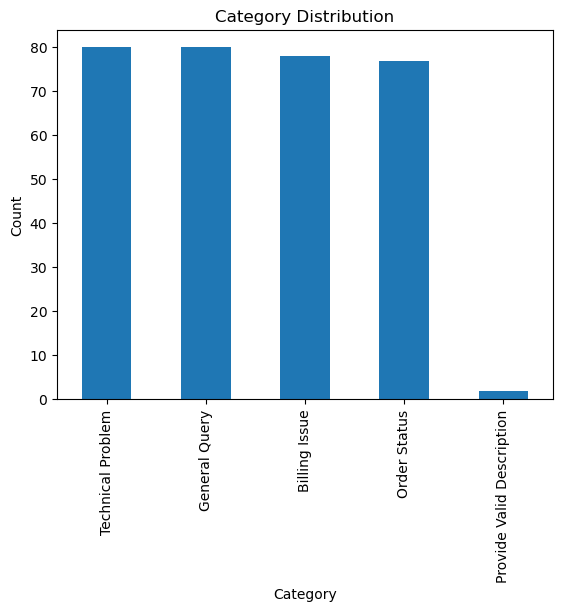

In [5]:

# =====================================================
# Step 6: Verify Category Distribution
# =====================================================
# Print the unique categories present in the dataset and their counts.
# This helps in understanding the distribution of different ticket categories and identifying
# potential class imbalance issues.
print("\nUnique categories in dataset:")
print(df["category"].value_counts())

# Print the total number of rows and the number of unique descriptions after cleaning.
# This serves as a verification step to confirm the effect of removing missing values and duplicates.
print("\nTotal rows in dataset:", df.shape[0])
print("Unique description rows:", df["description"].nunique())

# Visualize the distribution of categories using a bar plot.
# A bar plot provides a clear visual representation of the number of tickets in each category.
df["category"].value_counts().plot(kind="bar", title="Category Distribution")
plt.xlabel("Category") # Label for the x-axis.
plt.ylabel("Count") # Label for the y-axis.
plt.show() # Display the generated plot.


### Display DataFrame Information

Print the column names and display the head of the cleaned DataFrame to verify the preprocessing steps.

In [6]:

# =====================================================
# Step 7: Display DataFrame Information
# =====================================================
# Print the column names of the DataFrame to verify the column standardization and addition of 'clean_text'.
print(df.columns)
# Display the first few rows of the DataFrame, including the new 'clean_text' column,
# to visually inspect the results of the cleaning process and ensure data integrity.
print(df.head())

Index(['ticket_id', 'description', 'category', 'clean_text'], dtype='object')
   ticket_id                                 description           category  \
0          1        Why was extra delivery charge added?      Billing Issue   
1          2      Unable to update my profile in the app  Technical Problem   
2          3            Courier details are not updating       Order Status   
3          4  What are your customer care working hours?      General Query   
4          5            I was charged twice for my order      Billing Issue   

                    clean_text  
0  extra delivery charge added  
1    unable update profile app  
2      courier detail updating  
3   customer care working hour  
4          charged twice order  


### Feature Engineering - TF-IDF Vectorization

Convert the cleaned text data into numerical features using TF-IDF vectorization. Split the data into training and testing sets while maintaining the category distribution.

In [7]:
# =====================================================
# Step 8: Feature Engineering - TF-IDF Vectorization
# =====================================================
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets.
from sklearn.feature_extraction.text import TfidfVectorizer # For converting text data into TF-IDF features.

# Define features (X) and labels (y)
# X is the cleaned text data from the 'clean_text' column, which will be used as features for the model.
X = df["clean_text"]
# y is the category from the 'category' column, which will be used as the target variable (labels).
y = df["category"]

# Train-Test Split (80% train, 20% test)
# Split the data into training and testing sets to evaluate model performance on unseen data.
# A test size of 0.2 means 20% of the data will be used for testing.
# random_state=42 ensures reproducibility of the split.
# stratify=y ensures that the proportion of categories is the same in both train and test sets,
# which is important for maintaining class distribution in imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize TF-IDF Vectorizer
# Initialize the TF-IDF Vectorizer to convert the text data into numerical features.
# TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects
# how important a word is to a document in a collection or corpus.
vectorizer = TfidfVectorizer(
    max_features=5000,   # limit to top 5000 features based on term frequency across the corpus to reduce dimensionality and noise.
    ngram_range=(1,2),   # include both unigrams (single words) and bigrams (two consecutive words) as features to capture more context.
    stop_words="english" # remove common english stopwords during the vectorization process.
)

# Fit & Transform training data, Transform test data
# Fit the vectorizer on the training data (X_train) to learn the vocabulary and inverse document frequencies (idf) from the training corpus.
X_train_tfidf = vectorizer.fit_transform(X_train)
# Transform the training data into a TF-IDF matrix.
# Transform the test data (X_test) into a TF-IDF matrix using the vocabulary and idf values learned from the training data.
# It's crucial to only 'transform' the test data and not 'fit_transform' to avoid data leakage from the test set into the training process.
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF Training Shape:", X_train_tfidf.shape) # Print the shape of the TF-IDF matrix for the training data (number of samples, number of features).
print("TF-IDF Testing Shape:", X_test_tfidf.shape) # Print the shape of the TF-IDF matrix for the testing data.

TF-IDF Training Shape: (253, 968)
TF-IDF Testing Shape: (64, 968)


### Install XGBoost

Install the XGBoost library, which is used as one of the classification models.

In [8]:
# =====================================================
# Step 9: Install XGBoost
# =====================================================
# Install the XGBoost library
# This line installs the xgboost library using pip, allowing it to be used for building the XGBoost classifier model.
# The `!{sys.executable} -m pip install xgboost` command ensures that pip from the currently active Python environment is used.
import sys
!{sys.executable} -m pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


### Model Training, Evaluation & Comparison

Train multiple classification models (Naive Bayes, Logistic Regression, Linear SVC, XGBoost) on the training data. Evaluate their performance on the test set using accuracy, classification reports, and confusion matrices. Compare the initial performance of the models.


Training Naive Bayes...
Naive Bayes Accuracy: 0.9531
                   precision    recall  f1-score   support

    Billing Issue       0.94      1.00      0.97        16
    General Query       1.00      0.94      0.97        16
     Order Status       0.88      0.94      0.91        16
Technical Problem       1.00      0.94      0.97        16

         accuracy                           0.95        64
        macro avg       0.96      0.95      0.95        64
     weighted avg       0.96      0.95      0.95        64



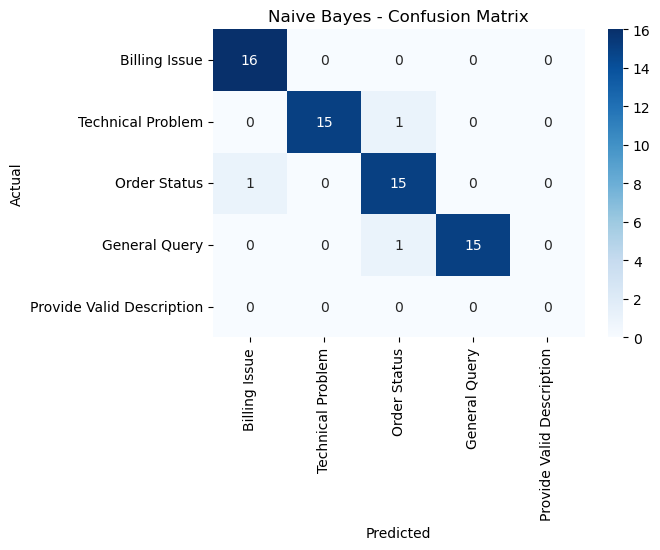


Training Logistic Regression...
Logistic Regression Accuracy: 0.9219
                   precision    recall  f1-score   support

    Billing Issue       0.94      0.94      0.94        16
    General Query       1.00      0.88      0.93        16
     Order Status       0.79      0.94      0.86        16
Technical Problem       1.00      0.94      0.97        16

         accuracy                           0.92        64
        macro avg       0.93      0.92      0.92        64
     weighted avg       0.93      0.92      0.92        64



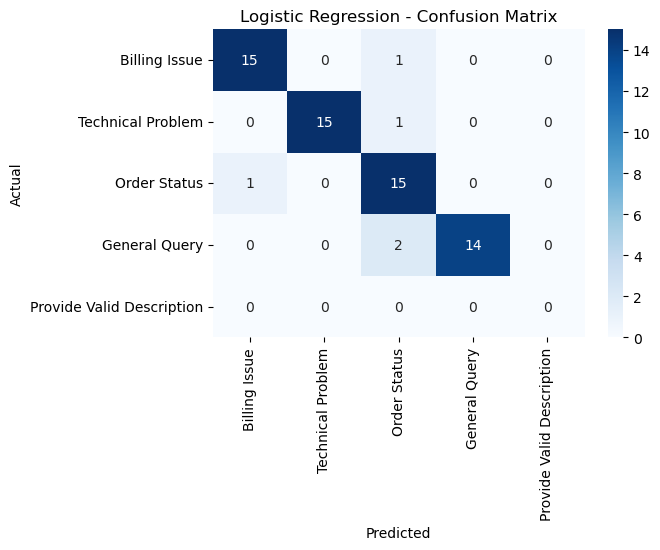


Training Linear SVC...
Linear SVC Accuracy: 0.9375
                   precision    recall  f1-score   support

    Billing Issue       0.94      1.00      0.97        16
    General Query       1.00      0.88      0.93        16
     Order Status       0.83      0.94      0.88        16
Technical Problem       1.00      0.94      0.97        16

         accuracy                           0.94        64
        macro avg       0.94      0.94      0.94        64
     weighted avg       0.94      0.94      0.94        64



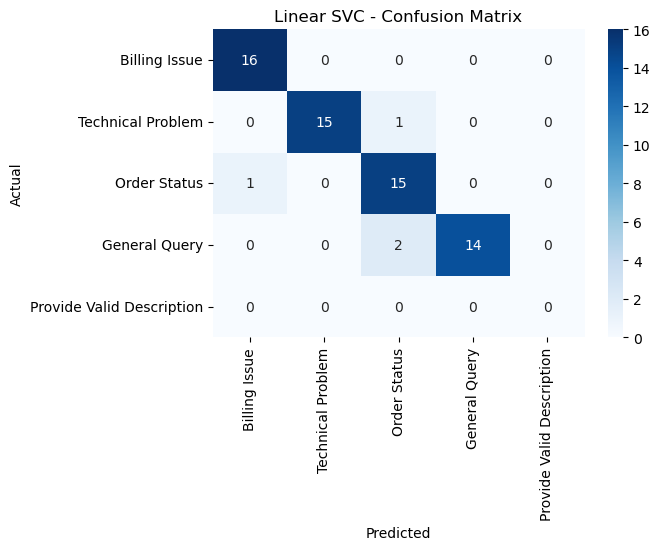


Training XGBoost...
XGBoost Accuracy: 0.7344
                   precision    recall  f1-score   support

    Billing Issue       0.90      0.56      0.69        16
    General Query       1.00      0.69      0.81        16
     Order Status       0.50      1.00      0.67        16
Technical Problem       1.00      0.69      0.81        16

         accuracy                           0.73        64
        macro avg       0.85      0.73      0.75        64
     weighted avg       0.85      0.73      0.75        64



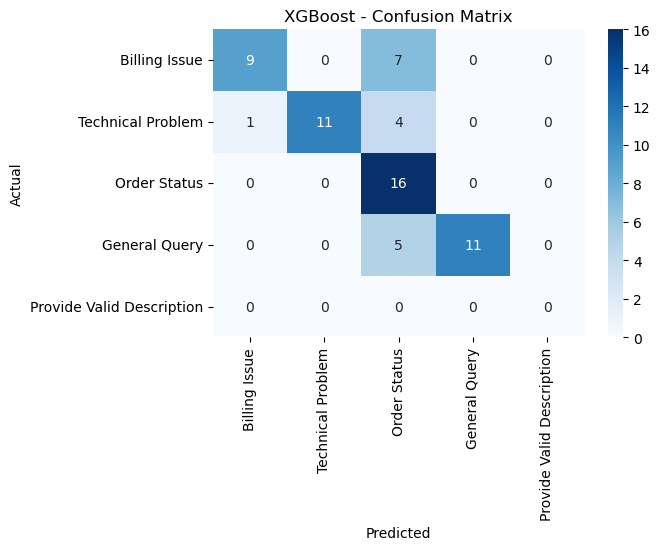

In [9]:
# =====================================================
# Step 10: Model Training, Evaluation & Comparison
# =====================================================
# Import necessary modules for model training, evaluation, and comparison.
from sklearn.naive_bayes import MultinomialNB # Import the Multinomial Naive Bayes classifier.
from sklearn.linear_model import LogisticRegression # Import the Logistic Regression classifier.
from sklearn.svm import LinearSVC # Import the Linear Support Vector Classifier.
from xgboost import XGBClassifier # Import the XGBoost classifier.
# Import evaluation metrics and visualization libraries.
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # For evaluating model performance.
import seaborn as sns # For creating informative statistical graphics.
from sklearn.preprocessing import LabelEncoder # For encoding categorical labels into numerical format.

# Split data
# Use the already split and transformed data from the previous cell (TF-IDF features).
# X_train and X_test contain the TF-IDF vectorized training and testing data respectively.
X_train = X_train_tfidf
X_test = X_test_tfidf
# y_train and y_test contain the original training and testing labels respectively.
# y is the full set of original labels, used here to get unique labels for the confusion matrix.
y = df["category"]

# Encode labels for XGBoost
# XGBoost requires numerical labels, so we encode the categorical labels using LabelEncoder.
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) # Fit the encoder on training labels and transform them.
y_test_encoded = le.transform(y_test) # Transform testing labels using the same encoder fitted on training data.


# Define models
# Define a dictionary of models to be trained and evaluated.
# Each key is the model name and the value is the initialized model object with specific parameters.
models = {
    "Naive Bayes": MultinomialNB(), # Initialize Multinomial Naive Bayes.
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs"), # Initialize Logistic Regression with increased max_iter and solver.
    "Linear SVC": LinearSVC(), # Initialize Linear Support Vector Classifier.
    "XGBoost": XGBClassifier(
        eval_metric="mlogloss", # Set evaluation metric for XGBoost.
        use_label_encoder=False, # Set to False to avoid deprecation warning.
        random_state=42 # Set random state for reproducibility.
    )
}

results = {} # Dictionary to store model accuracies for easy comparison later.

# Train & evaluate each model
# Iterate through each model defined in the 'models' dictionary.
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Use encoded labels for XGBoost (y_train_encoded), original labels for others (y_train).
    if name == "XGBoost":
        model.fit(X_train, y_train_encoded) # Train XGBoost with encoded labels.
        y_pred_encoded = model.predict(X_test) # Predict on test data (encoded output).
        y_pred = le.inverse_transform(y_pred_encoded) # Inverse transform predictions to get original labels for metrics.
    else:
        model.fit(X_train, y_train) # Train other models with original labels.
        y_pred = model.predict(X_test) # Predict on test data.

    # Accuracy
    # Calculate and print the accuracy of the model on the test set.
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    # Print the classification report, which includes precision, recall, and f1-score for each class.
    print(classification_report(y_test, y_pred))
    results[name] = acc # Store the accuracy in the results dictionary.

    # Confusion Matrix
    # Generate and display the confusion matrix to visualize model performance per class.
    # labels=y.unique() ensures all possible categories are included in the matrix.
    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    plt.figure(figsize=(6, 4)) # Set the size of the plot.
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", # Create a heatmap for the confusion matrix.
                xticklabels=y.unique(), yticklabels=y.unique()) # Set x and y axis labels to unique categories.
    plt.title(f"{name} - Confusion Matrix") # Set the title of the plot.
    plt.xlabel("Predicted") # Label for the x-axis.
    plt.ylabel("Actual") # Label for the y-axis.
    plt.show() # Display the generated plot.



### Compare Models (Bar Chart) 

Visualize the initial accuracy comparison of the models using a bar chart.

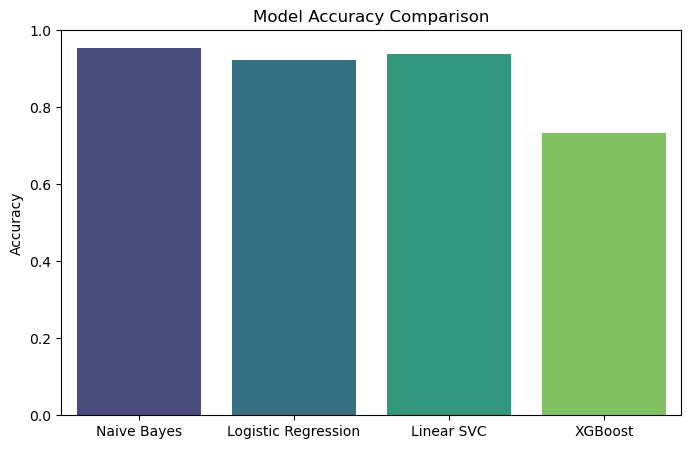


Model Comparison:
Naive Bayes: 0.9531
Logistic Regression: 0.9219
Linear SVC: 0.9375
XGBoost: 0.7344


In [10]:
# =====================================================
# Step 11: Compare Models (Bar Chart)
# =====================================================
# Create a bar chart to visually compare the accuracies of the different models.
plt.figure(figsize=(8, 5)) # Set the size of the plot.
# Create a bar plot using model names as x and accuracies as y.
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.title("Model Accuracy Comparison") # Set the title of the plot.
plt.ylabel("Accuracy") # Label for the y-axis.
plt.ylim(0, 1) # Set y-axis limits from 0 to 1 for better comparison of accuracy scores.
plt.show() # Display the generated plot.

# Print comparison table
# Print a summary table of model accuracies.
print("\nModel Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}") # Print each model's name and its accuracy, formatted to 4 decimal places.

### Hyperparameter Tuning using GridSearchCV

Perform hyperparameter tuning for several models (including Naive Bayes, Logistic Regression, Linear SVM, and XGBoost) using GridSearchCV with cross-validation to find the best parameters for each model.

In [11]:
# =====================================================
# Step 12: Hyperparameter Tuning using GridSearchCV (All Models)
# =====================================================
# Import necessary modules for hyperparameter tuning and models.
from sklearn.model_selection import GridSearchCV # For performing grid search with cross-validation.
from sklearn.svm import LinearSVC # Import SVC for Linear SVM tuning.
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder (already used, but explicitly imported for this section).

import joblib # Import joblib if needed for saving/loading in this cell, though it's primarily used later.

# Ensure X_train, y_train, y_train_encoded, and models dictionary are available from previous steps.

# ================================
# 1. Naive Bayes Tuning
# ================================
print("\nPerforming Naive Bayes Hyperparameter Tuning...")
# Define parameter grid for Naive Bayes tuning.
nb_params = {
    "alpha": [0.1, 0.5, 1.0, 2.0] # Smoothing parameter: values to test for alpha.
}
# Initialize Naive Bayes model.
nb = MultinomialNB()
# Perform GridSearchCV to find the best parameters for Naive Bayes.
# cv=5: use 5-fold cross-validation. scoring="accuracy": optimize for accuracy. n_jobs=-1: use all available CPU cores.
nb_grid = GridSearchCV(nb, nb_params, cv=5, scoring="accuracy", n_jobs=-1)
nb_grid.fit(X_train, y_train) # Fit the grid search model on the training data and original labels.

print("\nBest Naive Bayes Params:", nb_grid.best_params_) # Print the best parameters found by GridSearchCV.
print("Best NB Accuracy:", nb_grid.best_score_) # Print the mean cross-validation accuracy achieved with the best parameters.

# Update the models dictionary with the best Naive Bayes estimator found
models["Naive Bayes"] = nb_grid.best_estimator_


# ================================
# 2. Logistic Regression Tuning
# ================================
print("\nPerforming Logistic Regression Hyperparameter Tuning...")
# Define parameter grid for Logistic Regression tuning.
log_params = {
    "C": [0.01, 0.1, 1, 10], # Inverse of regularization strength: values to test for C.
    "penalty": ["l2"], # Type of regularization: testing only l2 penalty.
    "solver": ["liblinear", "saga"] # Algorithm to use in the optimization problem: testing liblinear and saga solvers.
}
# Initialize Logistic Regression model.
log_reg = LogisticRegression(max_iter=500, random_state=42) # Initialize with max_iter and random_state.
# Perform GridSearchCV to find the best parameters for Logistic Regression.
# cv=5, scoring="accuracy", n_jobs=-1 as described above.
log_grid = GridSearchCV(log_reg, log_params, cv=5, scoring="accuracy", n_jobs=-1)
log_grid.fit(X_train, y_train) # Fit the grid search model on the training data and original labels.

print("\nBest Logistic Regression Params:", log_grid.best_params_) # Print the best parameters found.
print("Best Logistic Regression Accuracy:", log_grid.best_score_) # Print the best mean cross-validation accuracy.

# Update the models dictionary with the best Logistic Regression estimator found
models["Logistic Regression"] = log_grid.best_estimator_


# ================================
# 3. Linear SVC Tuning
# ================================
print("\nPerforming Linear SVC Hyperparameter Tuning...")
# Define parameter grid for Linear SVC tuning.
svc_params = {
    "C": [0.01, 0.1, 1, 10],  # Regularization strength: values to test for C. C is the inverse of regularization strength. Smaller values specify stronger regularization.
    "max_iter": [1000, 2000]     # optional, in case of convergence warnings
}

# Initialize LinearSVC
svc = LinearSVC(random_state=42)
# Perform GridSearchCV to find the best parameters.
svc_grid = GridSearchCV(svc, svc_params, cv=3, scoring="accuracy", n_jobs=-1)
svc_grid.fit(X_train, y_train)

print("\nBest Linear SVC Params:", svc_grid.best_params_) # Print the best parameters found by GridSearchCV.
print("Best Linear SVC Accuracy:", svc_grid.best_score_) # Print the mean cross-validation accuracy achieved with the best parameters.
# Update the models dictionary with the best Linear SVM estimator found
models["Linear SVC"] = svc_grid.best_estimator_

# ================================
# 4. XGBoost Tuning
# ================================
print("\nPerforming XGBoost Hyperparameter Tuning...")
# Define parameter grid for XGBoost tuning.
xgb_params = {
    "n_estimators": [100, 200], # Number of boosting rounds
    "max_depth": [3, 5], # Maximum tree depth
    "learning_rate": [0.1, 0.3] # Step size shrinkage used in update to prevent overfitting
}

# Initialize XGBoost model.
xgb = XGBClassifier(eval_metric="mlogloss", use_label_encoder=False, random_state=42)
# Perform GridSearchCV to find the best parameters for XGBoost using encoded labels.
# Note: y_train_encoded is required for XGBoost.
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring="accuracy", n_jobs=-1)
xgb_grid.fit(X_train, y_train_encoded) # Fit the grid search model

print("\nBest XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost CV Accuracy:", xgb_grid.best_score_)

# Update the models dictionary with the best XGBoost estimator found
models["XGBoost"] = xgb_grid.best_estimator_


Performing Naive Bayes Hyperparameter Tuning...

Best Naive Bayes Params: {'alpha': 0.1}
Best NB Accuracy: 0.9683137254901961

Performing Logistic Regression Hyperparameter Tuning...

Best Logistic Regression Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression Accuracy: 0.968392156862745

Performing Linear SVC Hyperparameter Tuning...

Best Linear SVC Params: {'C': 1, 'max_iter': 1000}
Best Linear SVC Accuracy: 0.9684407096171802

Performing XGBoost Hyperparameter Tuning...

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best XGBoost CV Accuracy: 0.7944444444444444


### Cross-Validation for All Models & Evaluation

Perform cross-validation on the training data using the tuned models to get a more robust estimate of their performance and evaluate the tuned models across multiple metrics (accuracy, precision, recall, f1-score) to get a comprehensive understanding of their performance.

In [12]:
# =========================================================
# Step 13: Cross-Validation for All Models and Evaluation
# =========================================================

from sklearn.model_selection import cross_validate

# Use tuned models
models_to_eval = {
    "Naive Bayes": models["Naive Bayes"],
    "Logistic Regression": models["Logistic Regression"],
    "Linear SVC": models["Linear SVC"],
    "XGBoost": models["XGBoost"]
}

scoring = {
    "accuracy": "accuracy",
    "precision": "precision_macro",
    "recall": "recall_macro",
    "f1": "f1_macro"
}

cv_results = []       # store mean accuracy for model selection
cv_metric_results = []  # store all metrics

print("\nPerforming Cross-Validation (5-fold) with Tuned Models...")

for name, model in models_to_eval.items():
    if name == "XGBoost":
        scores = cross_validate(model, X_train, y_train_encoded, cv=5, scoring=scoring, n_jobs=-1)
    else:
        scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    
    mean_accuracy = scores["test_accuracy"].mean()
    std_accuracy = scores["test_accuracy"].std()
    cv_results.append((name, mean_accuracy))  # store for best model selection
    
    # Store detailed metrics
    cv_metric_results.append({
        "Model": name,
        "Accuracy (mean)": mean_accuracy,
        "Accuracy (std)": std_accuracy,
        "Precision (mean)": scores["test_precision"].mean(),
        "Recall (mean)": scores["test_recall"].mean(),
        "F1-score (mean)": scores["test_f1"].mean()
    })
    
    print(f"{name} CV Accuracy: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")

# Convert to DataFrame for display
cv_metrics_df = pd.DataFrame(cv_metric_results)
print("\nCross-Validation Summary (All Metrics):")
display(cv_metrics_df.round(4))




Performing Cross-Validation (5-fold) with Tuned Models...
Naive Bayes CV Accuracy: 0.9683 (+/- 0.0160)
Logistic Regression CV Accuracy: 0.9684 (+/- 0.0096)
Linear SVC CV Accuracy: 0.9723 (+/- 0.0097)
XGBoost CV Accuracy: 0.8225 (+/- 0.0471)

Cross-Validation Summary (All Metrics):


,Model,Accuracy (mean),Accuracy (std),Precision (mean),Recall (mean),F1-score (mean)
0,Naive Bayes,0.9683,0.0160,0.8922,0.8968,0.8937
1,Logistic Regression,0.9684,0.0096,0.8938,0.8973,0.8944
2,Linear SVC,0.9723,0.0097,0.8962,0.9006,0.8974
3,XGBoost,0.8225,0.0471,0.7965,0.7668,0.7650


### Save Best Model & Vectorizer

Identify the best-performing model based on CV results and save the trained model and the fitted TF-IDF vectorizer to disk using joblib for later use in prediction.

In [13]:
# =====================================================
# Step 14: Save Best Model & Vectorizer
# =====================================================
import joblib
# Select best model based on mean accuracy
best_model_name = max(cv_results, key=lambda x: x[1])[0]
print(f"\nBest model based on CV accuracy: {best_model_name}")
final_model = models_to_eval[best_model_name]

# Retrain on the full training data
if best_model_name == "XGBoost":
    final_model.fit(X_train, y_train_encoded)
else:
    final_model.fit(X_train, y_train)

# Save the final trained model and the fitted TF-IDF vectorizer using joblib.
joblib.dump(final_model, "ticket_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("\nSaved best model as 'ticket_classifier.pkl'")
print("\nSaved TF-IDF vectorizer as 'tfidf_vectorizer.pkl'")


Best model based on CV accuracy: Linear SVC

Saved best model as 'ticket_classifier.pkl'

Saved TF-IDF vectorizer as 'tfidf_vectorizer.pkl'


### Final Model Comparison & Visualization

Compile a final comparison table of the models based on test set evaluation metrics (accuracy, precision, recall, f1-score) and visualize this comparison using a bar plot.


Final Test Set Comparison:


,Model,Test Accuracy,Precision (macro),Recall (macro),F1-score (macro)
0,Naive Bayes,0.9531,0.9566,0.9531,0.9535
1,Logistic Regression,0.9062,0.9219,0.9062,0.9088
2,Linear SVC,0.9375,0.9436,0.9375,0.9383
3,XGBoost,0.7344,0.8500,0.7344,0.7472


<Figure size 1200x600 with 0 Axes>

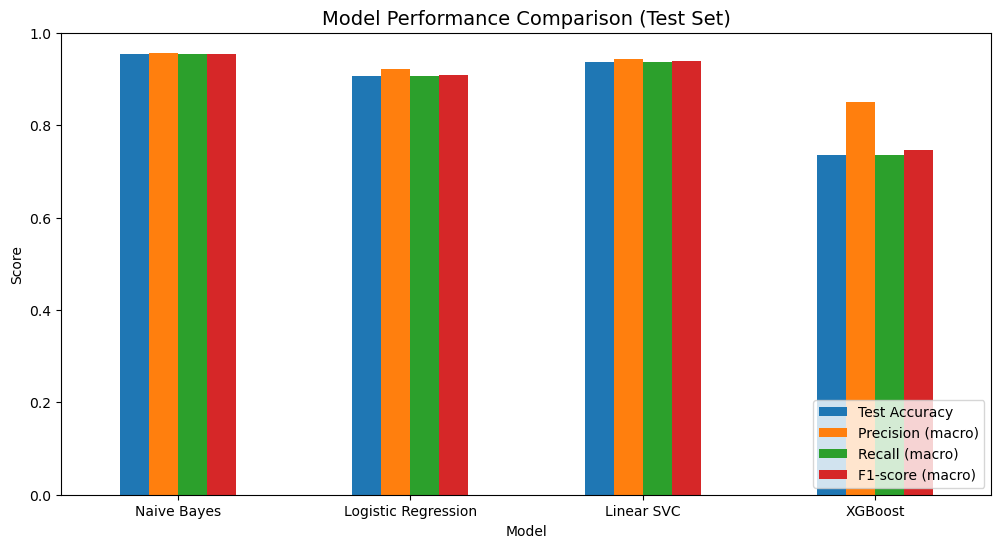

In [14]:
# =====================================================
# Step 15: Final Model Comparison (Test Set) & Visualization
# =====================================================
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

final_results = []

for name, model in models_to_eval.items():
    # Use XGBoost encoded labels if necessary
    if name == "XGBoost":
        y_pred_encoded = model.predict(X_test)
        y_pred = le.inverse_transform(y_pred_encoded)
    else:
        y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    # Use the initial test accuracy or recompute if needed
    test_accuracy = (y_pred == y_test).mean()
    
    final_results.append({
        "Model": name,
        "Test Accuracy": test_accuracy,
        "Precision (macro)": report["macro avg"]["precision"],
        "Recall (macro)": report["macro avg"]["recall"],
        "F1-score (macro)": report["macro avg"]["f1-score"]
    })

final_df = pd.DataFrame(final_results)
print("\nFinal Test Set Comparison:")
display(final_df.round(4))

# =====================================================
# Barplot Visualization
# =====================================================
metrics = ["Test Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"]

plt.figure(figsize=(12, 6))
final_df.set_index("Model")[metrics].plot(kind="bar", figsize=(12,6))
plt.title("Model Performance Comparison (Test Set)", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


### Create Frontend Directory for Flask Templates

Create a directory named 'frontend' to organize HTML templates for a potential web application.

In [15]:
# =====================================================
# Step 16: Create Frontend Directory for Flask Templates
# =====================================================
# Creation of frontend directory for Flask templates
# This command creates a directory named 'frontend' to store HTML templates for the Flask application.
!mkdir frontend

A subdirectory or file frontend already exists.


### Install Necessary Libraries for Flask App

Install Flask, flask-ngrok, and joblib to set up a basic web application environment

In [16]:
# =====================================================
# Step 17: Install Necessary Libraries for Flask App
# =====================================================
# Install necessary libraries for the Flask app
# This cell installs the required Python packages to run the Flask web application:
# - flask: The micro web framework.
# - flask-ngrok: Allows exposing the local Flask server running in Colab to the internet via an ngrok tunnel.
# - joblib: Used for loading the pre-trained machine learning model and TF-IDF vectorizer.
# - scikit-learn: Provides the machine learning tools used, although primarily needed for the vectorizer here.
import sys
!{sys.executable} -m pip install flask flask-ngrok joblib scikit-learn

Defaulting to user installation because normal site-packages is not writeable


### Simple Flask App

Implement a basic Flask application that loads the saved model and vectorizer, defines a text cleaning function, and sets up routes for the home page and prediction. This step demonstrates how the trained model can be integrated into a web service.

In [ ]:
# =====================================================
# Step 18: Simple Flask App
# =====================================================
# This cell contains the code for a simple Flask web application that serves the trained ticket classification model.
from flask import Flask, request, jsonify, render_template
from IPython.display import display, HTML
import re, os # Import re and os as they are used but were not explicitly imported before

# Create app
# Initializes the Flask application. The template_folder is set to "frontend" to specify where HTML templates are located.
app = Flask(__name__, template_folder="frontend")


# Load model + vectorizer (adjust paths if needed)
# Defines the file paths for the saved model and vectorizer.
MODEL_PATH = "ticket_classifier.pkl"
VECT_PATH  = "tfidf_vectorizer.pkl"

# Checks if the model and vectorizer files exist. If not, it raises a FileNotFoundError.
if not os.path.exists(MODEL_PATH) or not os.path.exists(VECT_PATH):
    raise FileNotFoundError("Place ticket_classifier.pkl and tfidf_vectorizer.pkl in the notebook folder")

# Loads the pre-trained model and TF-IDF vectorizer from the specified file paths using joblib.
# joblib was imported in a previous cell, so no need to import again.
model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECT_PATH)

# Defines a function to clean the input text, similar to the cleaning done during training.
def clean_text(text):
    # Ensures the input is a string.
    if not isinstance(text, str):
        return ""
    # Converts text to lowercase.
    text = text.lower()
    # Removes punctuation, numbers, and special characters.
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Replaces multiple spaces with a single space and removes leading/trailing spaces.
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Defines the route for the home page ('/').
@app.route('/')
def home():
    # Renders the 'index.html' template when the home page is accessed.
    return render_template('index.html')

# Defines the route for making predictions ('/predict'). It accepts POST requests.
@app.route('/predict', methods=['POST'])
def predict():
    # Gets the 'description' value from the submitted form data and removes leading/trailing spaces.
    raw = request.form.get('description', '').strip()
    # Cleans the raw input text using the clean_text function.
    cleaned = clean_text(raw)

    # Checks if the cleaned text is empty or contains fewer than 2 words.
    # If so, it returns a JSON response indicating that a valid description is needed.
    if not cleaned or len(cleaned.split()) < 2:
        return jsonify({"category": "Provide Valid Description", "input": raw})

    # Transforms the cleaned text into TF-IDF features using the loaded vectorizer.
    X = vectorizer.transform([cleaned])
    # Makes a prediction using the loaded model and gets the first (and only) prediction result.
    # LabelEncoder was imported in a previous cell, so no need to import again.
    if hasattr(model, 'predict_proba'): # Handle models that might output encoded labels (like XGBoost)
        # If the model was trained on encoded labels, inverse transform the prediction
        # Assuming 'le' (LabelEncoder) is available from previous steps
        pred_encoded = model.predict(X)[0]
        pred = le.inverse_transform([pred_encoded])[0]
    else: # For models trained on original labels
        pred = model.predict(X)[0]

    # Returns a JSON response containing the predicted category and the original input text.
    return jsonify({"category": pred, "input": raw})

# --- Run Flask + show clickable link ---
# Prints a message indicating that the Flask app is starting.
print("Starting Flask App...")
# Displays an HTML link to the local Flask app address. Note: This link is for the local server.
display(HTML('<a href="http://127.0.0.1:5000" target="_blank">🔗 Local Flask App</a>'))
# This block ensures that the Flask app runs only when the script is executed directly.
if __name__ == "__main__":
    # Runs the Flask development server. debug=False disables debug mode, use_reloader=False prevents the server from restarting automatically on code changes.
    # The server runs on http://127.0.0.1:5000 by default.
    app.run(debug=False, use_reloader=False)

Starting Flask App...


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
